# Hamiltonian Monte Carlo

Hamilton's equations

$$\begin{align}
\frac{dq}{dt} &= \phantom{-}\frac{\partial H}{\partial p} \\
\frac{dp}{dt} &= -\frac{\partial H}{\partial q}
\end{align}$$

For sampling, we set the Hamiltonian equal to

$$\begin{align}
P(q, p) = \frac{1}{Z} \underbrace{\exp\big(-U(q)\big)}_{\propto \text{ Target distribution}} \underbrace{\exp\big(-K(p)\big)}_{\propto \text{ Momenta distribution}}.
\end{align}$$

We set the momenta distribution to a Gaussian, using

$$\begin{align}
K(p) = \frac{p^2}{2m}.
\end{align}$$

One iteration of the leapfrog method does

$$\begin{align}
p\left(t + \epsilon~/~2\right) &= p(t) -  (\epsilon~/~2) \frac{\partial U}{\partial q} \Big |_{q(t)}, \\
q\left(t + \epsilon\right) &= q(t) + \epsilon~\frac{p\left(t + \epsilon~/~2\right)}{m}, \\
p\left(t + \epsilon\right) &= p\left(t + \epsilon~/~2\right) - (\epsilon~/~2) \frac{\partial U}{\partial q} \Big |_{q(t+\epsilon)}. \\
\end{align}$$

Multiple steps of the leapfrog method do

$$\begin{align}
\text{First step:} && p\left(t + \epsilon~/~2\right) &= p(t) -  (\epsilon~/~2) \frac{\partial U}{\partial q} \Big |_{q(t)},\\
k^{th}\text{ step for $q$:} && q\left(t + k\epsilon\right) &= q(t + (k-1)\epsilon) + \epsilon~\frac{p\left(t + k\epsilon - \epsilon~/~2\right)}{m}, \\
k^{th}\text{ step for $p$:} && p\left(t + k\epsilon + \epsilon~/~2\right) &= p(t + k\epsilon - \epsilon~/~2) -  \epsilon \frac{\partial U}{\partial q} \Big |_{q(t + k\epsilon)}, \\
\text{Last step:} && p\left(t + K\epsilon \right) &= p\left(t + K\epsilon - \epsilon~/~2\right) - (\epsilon~/~2) \frac{\partial U}{\partial q} \Big |_{q(t+K\epsilon)}. \\
\end{align}$$

The leapfrog method is reversible.

The acceptance log-probability of HMC is

$$\begin{align}
\log \alpha = \min\left\{0, -H(q^*, p^*) + H(q, p)\right\} = \min\left\{0, -U(q^*) + U(q) - K(p^*) + K(p)\right\}.
\end{align}$$

This acceptance probability leaves the canonical distribution $P(q, p)$ invariant. Therefore, the HMC update also leaves the target distribution invariant.

In [77]:
import matplotlib.pyplot as plt

In [78]:
from autograd import numpy as np
from autograd import grad

def hmc_transition(q0, U, m, L, epsilon):
    
    D = m.shape[0]
    
    dUdq = grad(U, argnum=0)
    
    # Arrays for storing q and p throughout the integration
    q = np.zeros(shape=(L, D))
    p = np.zeros(shape=(L+1, D))
    
    # Set initial values for q and p
    q[0, :] = q0
    p[0, :] = np.random.normal(loc=np.zeros_like(m),
                               scale=m**-0.5,
                               size=(m.shape[0],))
    
    # Initial leapfrog step
    p[1, :] = p[0, :] - 0.5 * epsilon * dUdq(q[0, :])
    
    # Iterated leapfrog steps
    for i in range(1, L):
        q[i, :] = q[i-1, :] + epsilon * p[i] / m
        p[i+1, :] = p[i, :] - epsilon * dUdq(q[i, :])
    
    # Last leapfrog step
    p[-1, :] = p[-2, :] - 0.5 * epsilon * dUdq(q[-1, :])
    
    Uterm = - U(q[-1, :]) + U(q[0, :])
    Kterm = - 0.5 * (np.sum(p[-1, :] ** 2 / m) - np.sum(p[0, :] ** 2 / m))
    Hdiff = Uterm + Kterm

    accept_prob = np.exp(Hdiff)
    
    qnew, accepted = (q[-1, :], True) if np.random.rand() <= accept_prob else \
                     (q[0, :], False)
    
    return qnew, accepted, accept_prob, q, p

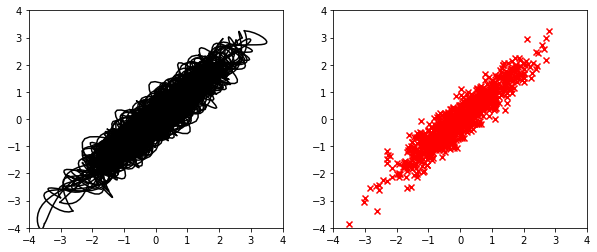

In [115]:
D = 2

q0 = np.ones(shape=(D,))

A = np.array([[1.0, 0.9],
              [0.9, 1.0]])

def U(q):
    return 0.5 * np.sum(q * np.linalg.solve(A, q))

m = np.ones(shape=(D,))
L = 20
epsilon = 1e-1

q_ = q0

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for i in range(1000):
    
    q_, accepted, accept_prob, q, p = hmc_transition(q0=q_, U=U, m=m, L=L, epsilon=epsilon)

    ax[0].plot(q[:, 0], q[:, 1], color='k')
    ax[1].scatter(q_[0], q_[1], marker='x', color='red')
    
ax[0].set_xlim([-4, 4])
ax[0].set_ylim([-4, 4])

ax[1].set_xlim([-4, 4])
ax[1].set_ylim([-4, 4])
plt.show()